# Understanding Hired Rides in NYC

_[Project prompt](https://docs.google.com/document/d/1VERPjEZcC1XSs4-02aM-DbkNr_yaJVbFjLJxaYQswqA/edit#)_


## Project Setup

In [1]:
# install needed libraries
"""!pip install pyarrow
!pip install fastparquet
!pip install geopandas
!pip install pytest
!pip install keplergl
!pip install bs4"""

'!pip install pyarrow\n!pip install fastparquet\n!pip install geopandas\n!pip install pytest\n!pip install keplergl\n!pip install bs4'

In [1]:
# all import statements needed for the project, for example:
import math
import bs4
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import requests
import sqlalchemy as db
import sqlite3
import numpy as np
import matplotlib.animation as animation
import keplergl
from keplergl import KeplerGl
import statistics
import unittest

In [2]:
# any constants you might need, for example:
TAXI_URL = "https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page"
# add other constants to refer to any local data, e.g. uber & weather
UBER_CSV = "uber_rides_sample.csv"
NEW_YORK_BOX_COORDS = ((40.560445, -74.242330), (40.908524, -73.717047))
DATABASE_URL = "sqlite:///project.db"
DATABASE_SCHEMA_FILE = "schema.sql"
QUERY_DIRECTORY = "queries"

## Part 1: Data Preprocessing

### Calculating distance
_**TODO:** Since we do not have trip distance information in our data, we need to calculate the distance from the latitude and longitude information of the pickup and dropoff locations. Here we use functions to complete the calculation and add the resulting trip distances to the dataframe._

In [4]:
# Calculate the distance between the two coordinates
def calculate_distance(from_coord: list, to_coord: list) -> float:
    R = 6373.0
    lat1 = math.radians(from_coord[0])
    lon1 = math.radians(from_coord[1])
    lat2 = math.radians(to_coord[0])
    lon2 = math.radians(to_coord[1])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance = R * c
    return distance

In [5]:
# unit test of calculate_distance function
def test_calculate_distance():
    # test basic functionality
    assert calculate_distance((40.560445, -74.242330),(40.908524, -73.717047)) == 58.8135468911925

In [6]:
test_calculate_distance()

In [6]:
# For the dataset that is not given the trip distance, calculate the distance using the given coordinate data and add it to the dataframe
def add_distance_column(dataframe: pd.core.frame.DataFrame) -> pd.core.frame.DataFrame:
    distance = []
    for index, row in dataframe.iterrows():
        distance.append(calculate_distance((row['pickup_latitude'], row['pickup_longitude']), (row['dropoff_latitude'], row['dropoff_longitude'])))
    dataframe['trip_distance'] = distance
    return dataframe

In [7]:
# unit test of add_distance_column function
def test_add_col():
    df = pd.DataFrame(
                    [[-74.242330, 40.560445, -73.717047, 40.908524]],
                    index=['1'],
                    columns=['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude'])
    # expected
    df_expected = pd.DataFrame(
                       [[-74.242330, 40.560445, -73.717047, 40.908524, calculate_distance((40.560445, -74.242330),(40.908524, -73.717047))]],
                       index=['1'],
                       columns=['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude','trip_distance'])
    # test the result
    assert add_distance_column(df).equals(df_expected)

In [9]:
test_add_col()

### Processing Taxi Data

_**TODO:** Use Beautiful Soup to get the required taxi data links from the New York government data website (https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page), read the data and convert the data into the same format._

In [14]:
# get taxi data from the website and generate a list of urls
def find_taxi_parquet_urls() -> list:
    response = requests.get(TAXI_URL)
    soup = bs4.BeautifulSoup(response.text, "html.parser")
    links = soup.find_all(lambda tag:'title' in tag.attrs and tag.attrs['title'] == "Yellow Taxi Trip Records")
    hrefs = [link.get('href') for link in links]
    # Filter the links based on the desired years (2009 to 2015)
    hrefs_filtered = [href for href in hrefs 
                  if any(year in href for year in map(str, range(2009, 2015)))
                  or (any(f"2015-{month:02}" in href for month in range(1, 7)))]
    return hrefs_filtered

In [11]:
# unit test of find_taxi_parquet_urls function
def test_find_taxi_parquet_urls():
    # test basic functionality
    assert find_taxi_parquet_urls() == ['https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2009-01.parquet',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2009-02.parquet',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2009-03.parquet',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2009-04.parquet',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2009-05.parquet',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2009-06.parquet',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2009-07.parquet',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2009-08.parquet',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2009-09.parquet',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2009-10.parquet',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2009-11.parquet',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2009-12.parquet',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2010-01.parquet',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2010-02.parquet',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2010-03.parquet',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2010-04.parquet',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2010-05.parquet',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2010-06.parquet',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2010-07.parquet',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2010-08.parquet',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2010-09.parquet',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2010-10.parquet',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2010-11.parquet',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2010-12.parquet',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2011-01.parquet',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2011-02.parquet',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2011-03.parquet',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2011-04.parquet',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2011-05.parquet',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2011-06.parquet',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2011-07.parquet',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2011-08.parquet',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2011-09.parquet',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2011-10.parquet',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2011-11.parquet',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2011-12.parquet',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2012-01.parquet',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2012-02.parquet',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2012-03.parquet',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2012-04.parquet',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2012-05.parquet',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2012-06.parquet',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2012-07.parquet',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2012-08.parquet',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2012-09.parquet',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2012-10.parquet',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2012-11.parquet',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2012-12.parquet',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2013-01.parquet',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2013-02.parquet',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2013-03.parquet',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2013-04.parquet',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2013-05.parquet',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2013-06.parquet',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2013-07.parquet',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2013-08.parquet',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2013-09.parquet',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2013-10.parquet',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2013-11.parquet',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2013-12.parquet',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2014-01.parquet',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2014-02.parquet',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2014-03.parquet',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2014-04.parquet',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2014-05.parquet',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2014-06.parquet',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2014-07.parquet',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2014-08.parquet',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2014-09.parquet',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2014-10.parquet',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2014-11.parquet',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2014-12.parquet',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2015-01.parquet',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2015-02.parquet',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2015-03.parquet',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2015-04.parquet',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2015-05.parquet',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2015-06.parquet']

In [12]:
test_find_taxi_parquet_urls()

In [13]:
# Define a function that converts location to coordinates, and generate a dataframe
def convert_id_to_coord(df: pd.core.frame.DataFrame) -> pd.core.frame.DataFrame:
    shapefile = gpd.read_file(r"C:\Users\Silvia\Documents\GitHub\4501FinalProject_Group14\taxi_zones\taxi_zones.shp")
    # Convert the geometry column in the shapefile into specific coordinates of latitude and longitude
    shapefile = shapefile.to_crs(4326)
    shapefile['latitude'] = shapefile['geometry'].centroid.y
    shapefile['longitude'] = shapefile['geometry'].centroid.x
    
    df = df
    df = df.loc[df["pulocationid"] <= 263]
    df = df.loc[df["pulocationid"] != 0]
    df = df.loc[df["dolocationid"] <= 263]
    df = df.loc[df["dolocationid"] != 0]
    # convert location IDs into longitude and latitude
    PUlongitude = []
    PUlatitude = []
    DOlongitude = []
    DOlatitude = []
    # convert the pickup location IDs into longitude and latitude
    for i in df['pulocationid']:
        PUlatitude.append(shapefile['latitude'][i-1])
        PUlongitude.append(shapefile['longitude'][i-1])
    for i in df['dolocationid']:
        DOlatitude.append(shapefile['latitude'][i-1])
        DOlongitude.append(shapefile['longitude'][i-1])
        
    df['pickup_longitude'] = PUlongitude
    df['pickup_latitude'] = PUlatitude
    df['dropoff_longitude'] = DOlongitude
    df['dropoff_latitude'] = DOlatitude
    # convert the drop off location IDs into longitude and latitude
    
    return df

In [14]:
# unit test of convert_id_to_coord function
def test_convert_id_to_coord():
    df = pd.DataFrame(
                    [[164, 4]],
                    index=['1'],
                    columns=['pulocationid', 'dolocationid'])
    df_expected = pd.DataFrame(
                    [[164, 4, -73.95682460583805,40.620924048746254, -73.976968, 40.723752]],
                    index=['1'],
                    columns=['pulocationid', 'dolocationid', 'pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude'])

In [15]:
test_convert_id_to_coord()

In [16]:
# Obtain taxi data and clean the data
def get_and_clean_month_taxi_data(url: str) -> pd.core.frame.DataFrame:

    df = pd.read_parquet(url)
    df.columns = df.columns.str.lower()
    df_taxi = pd.DataFrame()

    # keep necessary columns into a new dataframe
    if 'tpep_pickup_datetime' in df.columns:
        df=df.rename(columns = {'tpep_pickup_datetime':'pickup_datetime',
                                'tip_amount' : 'tip_amount'})
        df=convert_id_to_coord(df)
        
    elif 'trip_pickup_datetime' in df.columns:
        df=df.rename(columns = {'trip_pickup_datetime':'pickup_datetime', 
                                'start_lon': 'pickup_longitude',
                                'start_lat': 'pickup_latitude',
                                'end_lon': 'dropoff_longitude',
                                'end_lat': 'dropoff_latitude',
                                'tip_amt' : 'tip_amount'})
        
    df.drop(df.columns.difference(['pickup_datetime',
                                    'trip_distance', 
                                    'pickup_latitude', 
                                    'pickup_longitude', 
                                    'dropoff_latitude', 
                                    'dropoff_longitude',
                                   'tip_amount']), 1, inplace=True)
    
    df=df[df["pickup_longitude"] <= -73.717047]  
    df=df[df["pickup_longitude"] >= -74.242330]
    df=df[df["pickup_latitude"] >= 40.560445]
    df=df[df["pickup_latitude"] <= 40.908524]
    df=df[df["dropoff_longitude"] <= -73.717047]
    df=df[df["dropoff_longitude"] >= -74.242330]
    df=df[df["dropoff_latitude"] >= 40.560445]
    df=df[df["dropoff_latitude"] <= 40.908524]

    df = df.loc[df["pickup_datetime"] != 0.0]
    
    return df

In [17]:
# unit test of get_and_clean_month_taxi_data function
def test_get_and_clean_month_taxi_data():
    df = get_and_clean_month_taxi_data(url = 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2015-01.parquet')

    assert df.notnull().values.any() == True
    assert list(df.columns) == ['pickup_datetime','trip_distance','tip_amount','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude']
    assert df.dtypes['pickup_datetime'] == 'datetime64[ns]'

In [18]:
test_get_and_clean_month_taxi_data()

C:\Users\Silvia\AppData\Local\Temp\ipykernel_2664\4189018635.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  shapefile['latitude'] = shapefile['geometry'].centroid.y
C:\Users\Silvia\AppData\Local\Temp\ipykernel_2664\4189018635.py:7: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  shapefile['longitude'] = shapefile['geometry'].centroid.x


### Processing Uber Data

_**TODO:** Read uber's trip data and process it._

In [ ]:
# load uber data and clean the data
def load_and_clean_uber_data(csv_file: str) -> pd.core.frame.DataFrame:
    df = pd.read_csv(csv_file, on_bad_lines='skip')
    df.columns = df.columns.str.lower()
    add_distance_column(df)
    df.drop(df.columns.difference(['pickup_datetime',
                                     'trip_distance', 
                                     'pickup_latitude', 
                                     'pickup_longitude', 
                                     'dropoff_latitude', 
                                     'dropoff_longitude']), 1, inplace=True)

    # remove rows start and/or end outside of the following latitude/longitude coordinate box: 
    # (40.560445, -74.242330) and (40.908524, -73.717047)
    df=df[df["pickup_longitude"] <= -73.717047]  
    df=df[df["pickup_longitude"] >= -74.242330]
    df=df[df["pickup_latitude"] >= 40.560445]
    df=df[df["pickup_latitude"] <= 40.908524]
    df=df[df["dropoff_longitude"] <= -73.717047]
    df=df[df["dropoff_longitude"] >= -74.242330]
    df=df[df["dropoff_latitude"] >= 40.560445]
    df=df[df["dropoff_latitude"] <= 40.908524]

    # remove invalid rows thtat pickup time is 0
    df = df.loc[df["pickup_datetime"] != 0.0]

    df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])

    return df

In [ ]:
# unit test of load_and_clean_uber_data function
def test_load_and_clean_uber_data():
        df = load_and_clean_uber_data(r"C:\Users\Silvia\Downloads\uber_rides_sample.csv")
        assert list(df.columns) == ['pickup_datetime', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'trip_distance']
        assert df.shape == (195472, 6)

In [ ]:
test_load_and_clean_uber_data()

Sampling the taxi data according to the number of uber trips each month

In [ ]:
# Get the number of uber data per month
def get_number_to_sample() -> int:
    uber = load_and_clean_uber_data(r"C:\Users\Silvia\Downloads\uber_rides_sample.csv")
    uber.index = pd.to_datetime(uber['pickup_datetime'])
    number_each_month = uber.groupby(by=[uber.index.year, uber.index.month]).size()
    number = []
    for i in range(2009,2015):
        for j in range(1,13):
            number.append(number_each_month[i][j])
    for i in range(1,7):
        number.append(number_each_month[2015][i])
    return number

In [ ]:
# unit test of get_number_to_sample function
def test_get_number_to_sample():
      assert len(get_number_to_sample()) == 78

In [ ]:
number = get_number_to_sample()

C:\Users\Silvia\AppData\Local\Temp\ipykernel_19920\1263730049.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(df.columns.difference(['pickup_datetime',


In [ ]:
def get_sample_taxi_data() -> pd.core.frame.DataFrame:
    sample_taxi_dataframes = []
    
    all_parquet_urls = find_taxi_parquet_urls()
    # do the sampling of taxi data according to the number of uber trip each month
    for i in range(0, 78): 
        n = number[i]
        url = all_parquet_urls[i]
        df = get_and_clean_month_taxi_data(url)
        df_sample = df.sample(n)
        sample_taxi_dataframes.append(df_sample)

    taxi_data = pd.concat(sample_taxi_dataframes)
    taxi_data['pickup_datetime'] = pd.to_datetime(taxi_data['pickup_datetime'])
    taxi_data = taxi_data.reset_index(drop = True)
    return taxi_data

In [ ]:
# unit test of get_sample_taxi_data function
def test_get_sample_taxi_data():
    df = get_sample_taxi_data()
    assert list(df.columns) == ['pickup_datetime', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'trip_distance','tip_amount']
    assert df.shape == (195472, 7)


In [ ]:
test_get_sample_taxi_data()

### Processing Weather Data

_**TODO:** Write some prose that tells the reader what you're about to do here._

In [ ]:
def clean_month_weather_data_hourly(csv_file: str) -> pd.core.frame.DataFrame:
    # read file
    df = pd.read_csv(csv_file)
    #drop unnecessary colums
    df.drop(df.columns.difference(['DATE',
                                   'HourlyPrecipitation', 
                                   'HourlyWindSpeed']), 1, inplace=True)
    df['HourlyPrecipitation'] = df['HourlyPrecipitation'].replace('T', 0.0)
    # drop na values
    df.dropna(subset=['HourlyWindSpeed'], inplace=True)
    # convert "DATE" to datetime type
    df['DATE'] = pd.to_datetime(df['DATE'])
    # convert "HourlyPrecipitation" to float type
    df['HourlyPrecipitation'] = pd.to_numeric(df['HourlyPrecipitation'], errors='coerce')
    # fill in missing values
    df['HourlyPrecipitation'].fillna(0, inplace=True)
    # cast "df" to specified type
    df = df.astype({'HourlyWindSpeed': 'float32', 'HourlyPrecipitation': 'float32'})

    return df

In [ ]:
# unit test of clean_month_weather_data_hourly function
def test_clean_month_weather_data_hourly():
    df = clean_month_weather_data_hourly(r'C:\Users\Silvia\Downloads\2009_weather.csv')
    assert list(df.columns) == ['DATE', 'HourlyPrecipitation', 'HourlyWindSpeed']
    assert df.dtypes['DATE'] == 'datetime64[ns]'
    assert df.dtypes['HourlyWindSpeed'] == 'float32'
    assert df.dtypes['HourlyPrecipitation'] == 'float32'

In [ ]:
test_clean_month_weather_data_hourly()

In [ ]:
def clean_month_weather_data_daily(csv_file: str) -> pd.core.frame.DataFrame:
    # read file
    df = pd.read_csv(csv_file)
    # Replace data of the string type
    df['HourlyPrecipitation'] = df['HourlyPrecipitation'].replace('T', 0.0)
    # convert "DATE" to datetime type
    df['DATE'] = pd.to_datetime(df['DATE'])
    # convert "HourlyPrecipitation" to numeric type
    df['HourlyPrecipitation'] = pd.to_numeric(df['HourlyPrecipitation'], errors='coerce')
    # convert value of 'na' into 0.0
    df['HourlyPrecipitation'].fillna(0, inplace=True)
    #drop unnecessary colums
    df.drop(df.columns.difference(['DATE',
                                   'HourlyPrecipitation', 
                                   'HourlyWindSpeed']), 1, inplace=True)
    # calculate hourly average as a daily values
    df['DATE'] = df['DATE'].dt.date
    df = df.groupby('DATE', as_index=False).agg({'HourlyWindSpeed': np.mean, 'HourlyPrecipitation': np.mean})
    df['HourlyWindSpeed'] = df['HourlyWindSpeed'].map(lambda x: round(x, 2))
    # remame columns
    df.rename(columns={'HourlyWindSpeed': 'DailyAverageWindSpeed', 'HourlyPrecipitation': 'DailyPrecipitation'}, inplace=True)
    df = df.astype({'DailyAverageWindSpeed':'float32', 'DailyPrecipitation':'float32', 'DATE' : 'datetime64[ns]'})

    return df

In [ ]:
# unit test of clean_month_weather_data_daily function
def test_clean_month_weather_data_daily():
    df = clean_month_weather_data_daily(r'C:\Users\Silvia\Downloads\2009_weather.csv')
    assert list(df.columns) == ['DATE', 'DailyAverageWindSpeed', 'DailyPrecipitation']
    assert df.dtypes['DATE'] == 'datetime64[ns]'
    assert df.dtypes['DailyAverageWindSpeed'] == 'float32'
    assert df.dtypes['DailyPrecipitation'] == 'float32'

In [ ]:
test_clean_month_weather_data_daily()

In [ ]:
def load_and_clean_weather_data() -> pd.core.frame.DataFrame:
    hourly_dataframes = []
    daily_dataframes = []
    
    # add some way to find all weather CSV files
    # or just add the name/paths manually
    weather_csv_files = [
            r"C:\Users\Silvia\Downloads\2009_weather.csv",
            r"C:\Users\Silvia\Downloads\2010_weather.csv",
            r"C:\Users\Silvia\Downloads\2011_weather.csv",
            r"C:\Users\Silvia\Downloads\2012_weather.csv",
            r"C:\Users\Silvia\Downloads\2013_weather.csv",
            r"C:\Users\Silvia\Downloads\2014_weather.csv",
            r"C:\Users\Silvia\Downloads\2015_weather.csv"
        ]
    
    for csv_file in weather_csv_files:
        hourly_dataframe = clean_month_weather_data_hourly(csv_file)
        daily_dataframe = clean_month_weather_data_daily(csv_file)
        hourly_dataframes.append(hourly_dataframe)
        daily_dataframes.append(daily_dataframe)
        
    # create two dataframes with hourly & daily data from every month
    hourly_data = pd.concat(hourly_dataframes)
    daily_data = pd.concat(daily_dataframes)
    
    return hourly_data, daily_data

In [ ]:
# unit test of clean_month_weather_data_daily function
def test_load_and_clean_weather_data():
    df_hourly_weather, df_daily_weather = load_and_clean_weather_data()
    assert list(df_hourly_weather.columns) ==  ['DATE', 'HourlyPrecipitation', 'HourlyWindSpeed']
    assert list(df_daily_weather.columns) == ['DATE', 'DailyAverageWindSpeed', 'DailyPrecipitation']

In [ ]:
test_load_and_clean_weather_data()

In [ ]:
def clean_sunset_sunrise_daily(csv_file: str) -> pd.core.frame.DataFrame:
    df = pd.read_csv(csv_file)
    df.drop(df.columns.difference(['DATE','Sunset','Sunrise']), 1, inplace=True)
    df = df.dropna()
    df['DATE'] = pd.to_datetime(df['DATE'])
    df = df.astype({'Sunrise': 'int32', 'Sunset': 'int32', 'DATE':'datetime64[ns]' })
    return df

In [ ]:
# unit test of clean_sunset_sunrise_daily function
def test_clean_sunset_sunrise_daily():
    df = clean_sunset_sunrise_daily('2009_weather.csv')
    assert list(df.columns) == ['DATE', 'Sunrise', 'Sunset']
    assert df.dtypes['DATE'] == 'datetime64[ns]'
    assert df.dtypes['Sunrise'] == 'int32'
    assert df.dtypes['Sunset'] == 'int32'

In [ ]:
test_clean_sunset_sunrise_daily()

In [ ]:
def load_and_clean_sunrise_sunset_data() -> pd.core.frame.DataFrame:
    sunrise_sunset_dataframes =[]
    
    weather_csv_files = [
            r"C:\Users\Silvia\Downloads\2009_weather.csv",
            r"C:\Users\Silvia\Downloads\2010_weather.csv",
            r"C:\Users\Silvia\Downloads\2011_weather.csv",
            r"C:\Users\Silvia\Downloads\2012_weather.csv",
            r"C:\Users\Silvia\Downloads\2013_weather.csv",
            r"C:\Users\Silvia\Downloads\2014_weather.csv",
            r"C:\Users\Silvia\Downloads\2015_weather.csv"
        ]
    
    for csv_file in weather_csv_files:
        sunrise_sunset_dataframe = clean_sunset_sunrise_daily(csv_file)
        sunrise_sunset_dataframes.append(sunrise_sunset_dataframe)
        
    sunrise_sunset_data = pd.concat(sunrise_sunset_dataframes)
    sunrise_sunset_data['DATE'] = pd.to_datetime(sunrise_sunset_data['DATE'])
    sunrise_sunset_data = sunrise_sunset_data.astype({'Sunrise': 'int32', 'Sunset': 'int32'})
    
    return sunrise_sunset_data

In [ ]:
# unit test of load_and_clean_sunrise_sunset_data function
def test_load_and_clean_sunrise_sunset_data():
    df_sunrise_sunset = load_and_clean_sunrise_sunset_data()
    assert list(df_sunrise_sunset.columns) ==  ['DATE', 'Sunrise', 'Sunset']

In [ ]:
test_load_and_clean_sunrise_sunset_data()

### Process All Data

_This is where you can actually execute all the required functions._

_**TODO:** Write some prose that tells the reader what you're about to do here._

In [ ]:
taxi_data = get_sample_taxi_data()
uber_data = load_and_clean_uber_data(r"C:\Users\Silvia\Downloads\uber_rides_sample.csv")
hourly_weather_data, daily_weather_data = load_and_clean_weather_data()
sunrise_sunset_data = load_and_clean_sunrise_sunset_data()

C:\Users\Silvia\AppData\Local\Temp\ipykernel_19920\1263730049.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(df.columns.difference(['pickup_datetime',
C:\Users\Silvia\AppData\Local\Temp\ipykernel_19920\2099839999.py:3: DtypeWarning: Columns (9,13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file)
C:\Users\Silvia\AppData\Local\Temp\ipykernel_19920\2099839999.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(df.columns.difference(['DATE',
C:\Users\Silvia\AppData\Local\Temp\ipykernel_19920\2252719857.py:3: DtypeWarning: Columns (9,13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file)
C:\Users\Silvia\AppData\Local\Temp\ipykernel_19920\2252719857.py:13: FutureWarning: In a future version of 

C:\Users\Silvia\AppData\Local\Temp\ipykernel_19920\4001209316.py:2: DtypeWarning: Columns (8,9,17,18,78) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file)
C:\Users\Silvia\AppData\Local\Temp\ipykernel_19920\4001209316.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(df.columns.difference(['DATE','Sunset','Sunrise']), 1, inplace=True)
C:\Users\Silvia\AppData\Local\Temp\ipykernel_19920\4001209316.py:2: DtypeWarning: Columns (10,41,78) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file)
C:\Users\Silvia\AppData\Local\Temp\ipykernel_19920\4001209316.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(df.columns.difference(['DATE','Sunset','Sunrise']), 1, inplace=True)


## Part 2: Storing Cleaned Data

_Write some prose that tells the reader what you're about to do here._

In [ ]:
engine = db.create_engine(DATABASE_URL)

In [ ]:
from sqlalchemy import Column, Date, Integer, Float, String
from sqlalchemy.ext.declarative import declarative_base

Base = declarative_base()

In [ ]:
class HourlyWeather(Base):
    __tablename__ = 'hourly_weathers'
    
    id = Column(Integer, primary_key=True)
    Date = Column(Date)
    HourlyPrecipitation = Column(Float)
    HourlyWindSpeed = Column(Float)

class DailyWeather(Base):
    __tablename__ = 'daily_weathers'
    
    id = Column(Integer, primary_key=True)
    Date = Column(Date)
    DailyPrecipitation = Column(Float)
    DailyAverageWindSpeed = Column(Float)

class TaxiTrip(Base):
    __tablename__ = 'taxi_trips'
    
    id = Column(Integer, primary_key=True)
    pickup_datetime = Column(Date)
    trip_distance = Column(Float)
    pickup_longitude = Column(Float)
    pickup_latitude = Column(Float)
    dropoff_longitude = Column(Float)
    dropoff_latitude = Column(Float)

class UberTrip(Base):
    __tablename__ = 'uber_trips'
    
    id = Column(Integer, primary_key=True)
    pickup_datetime = Column(Date)
    trip_distance = Column(Float)
    pickup_longitude = Column(Float)
    pickup_latitude = Column(Float)
    dropoff_longitude = Column(Float)
    dropoff_latitude = Column(Float)

In [ ]:
class Sunrise_Sunset(Base):
    __tablename__ = 'sunrise_sunsets'
    
    id = Column(Integer, primary_key=True)
    Date = Column(Date)
    Sunrise = Column(Integer)
    Sunset = Column(Integer)

In [ ]:
# if using SQL (as opposed to SQLAlchemy), define the commands 
# to create your 4 tables/dataframes
HOURLY_WEATHER_SCHEMA = """
CREATE TABLE IF NOT EXISTS hourly_weather
(
    weatherId INTEGER PRIMARY KEY AUTOINCREMENT,
    Date DATE,
    HourlyPrecipitation FLOAT,
    HourlyWindSpeed FLOAT
);
"""

DAILY_WEATHER_SCHEMA = """
CREATE TABLE IF NOT EXISTS daily_weather
(
    weatherId INTEGER PRIMARY KEY AUTOINCREMENT
    Date DATE,
    DailyPrecipitation FLOAT,
    DailyAverageWindSpeed FLOAT
);
"""

TAXI_TRIPS_SCHEMA = """
CREATE TABLE IF NOT EXISTS taxi_trips
(
    taxi_tripId INTEGER PRIMARY KEY AUTOINCREMENT,
    pickup_datetime DATE,
    distance FLOAT,
    pickup_longitude FLOAT,
    pickup_latitude FLOAT,
    dropoff_longitude FLOAT,
    dropoff_latitude FLOAT
);
"""

UBER_TRIPS_SCHEMA = """
CREATE TABLE IF NOT EXISTS uber_trips
(
    uber_tripId INTEGER PRIMARY KEY AUTOINCREMENT,
    pickup_datetime DATE,
    distance FLOAT,
    pickup_longitude FLOAT,
    pickup_latitude FLOAT,
    dropoff_longitude FLOAT,
    dropoff_latitude FLOAT
);
"""

In [ ]:
SUNRISE_SUNSET_SCHEMA = """
CREATE TABLE IF NOT EXISTS sunrise_sunsets
(
    sunrise_sunsetID INTEGER PRIMARY KEY AUTOINCREMENT,
    Date DATE,
    Sunrise INTEGER,
    Sunset INTEGER
);
"""
with open(DATABASE_SCHEMA_FILE, "w") as f:
    f.write(SUNRISE_SUNSET_SCHEMA)

In [ ]:
# create that required schema.sql file
with open(DATABASE_SCHEMA_FILE, "w") as f:
    f.write(HOURLY_WEATHER_SCHEMA)
    f.write(DAILY_WEATHER_SCHEMA)
    f.write(TAXI_TRIPS_SCHEMA)
    f.write(UBER_TRIPS_SCHEMA)

In [ ]:
connection = sqlite3.connect("project.db")

### Add Data to Database

_**TODO:** Write some prose that tells the reader what you're about to do here._

In [ ]:
uber_data.to_sql("uber_trips", con = connection,schema=UBER_TRIPS_SCHEMA)
taxi_data.to_sql("taxi_trips", con = connection,schema=TAXI_TRIPS_SCHEMA)
daily_weather_data.to_sql("daily_weathers", con = connection,schema=DAILY_WEATHER_SCHEMA)
hourly_weather_data.to_sql("hourly_weathers", con = connection,schema=HOURLY_WEATHER_SCHEMA)

73713

In [ ]:
sunrise_sunset_data.to_sql("sunrise_sunsets", con = connection, schema=SUNRISE_SUNSET_SCHEMA)

1826

## Part 3: Understanding the Data

_A checklist of requirements to keep you on track. Remove this whole cell before submitting the project. The order of these tasks aren't necessarily the order in which they need to be done. It's okay to do them in an order that makes sense to you._

* [ ] For 01-2009 through 06-2015, what hour of the day was the most popular to take a yellow taxi? The result should have 24 bins.
* [ ] For the same time frame, what day of the week was the most popular to take an uber? The result should have 7 bins.
* [ ] What is the 95% percentile of distance traveled for all hired trips during July 2013?
* [ ] What were the top 10 days with the highest number of hired rides for 2009, and what was the average distance for each day?
* [ ] Which 10 days in 2014 were the windiest, and how many hired trips were made on those days?
* [ ] During Hurricane Sandy in NYC (Oct 29-30, 2012) and the week leading up to it, how many trips were taken each hour, and for each hour, how much precipitation did NYC receive and what was the sustained wind speed?

In [ ]:
def write_query_to_file(query: str, outfile: str):
    with open(outfile, "w") as f:
        f.write(query)
        f.close()

### Query N

_**TODO:** Write some prose that tells the reader what you're about to do here._

_Repeat for each query_

In [ ]:
QUERY_1 = """
SELECT strftime ('%H',pickup_datetime) AS HOUR,
COUNT(strftime ('%H',pickup_datetime)) AS Trip_counts
FROM taxi_trips
GROUP BY HOUR
ORDER BY Trip_counts DESC
"""

In [ ]:
engine.execute(QUERY_1).fetchall()

[('19', 12300),
 ('18', 11824),
 ('20', 11497),
 ('21', 11046),
 ('22', 10898),
 ('14', 9944),
 ('23', 9732),
 ('17', 9728),
 ('12', 9727),
 ('13', 9566),
 ('15', 9282),
 ('09', 9247),
 ('11', 9130),
 ('08', 8898),
 ('10', 8861),
 ('16', 8114),
 ('00', 7867),
 ('07', 7025),
 ('01', 5477),
 ('02', 4151),
 ('06', 4083),
 ('03', 3047),
 ('04', 2236),
 ('05', 1792)]

In [ ]:
write_query_to_file(QUERY_1, "most_popular_hour_taxi.sql")

In [ ]:
QUERY_2 = '''
SELECT strftime ('%w',pickup_datetime) AS Day,
COUNT(strftime ('%w',pickup_datetime)) AS Trip_counts
FROM uber_trips
GROUP BY Day
ORDER BY Trip_counts DESC
'''

In [ ]:
engine.execute(QUERY_2).fetchall()

[('5', 30166),
 ('6', 29599),
 ('4', 29338),
 ('3', 28328),
 ('2', 27526),
 ('0', 25834),
 ('1', 24681)]

In [ ]:
write_query_to_file(QUERY_2, "most_popular_day_uber.sql")

In [ ]:
QUERY_3 = """
SELECT distance FROM(
SELECT trip_distance AS distance
FROM (SELECT pickup_datetime, trip_distance, pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude from taxi_trips
WHERE pickup_datetime between '2013-07-01' AND '2013-07-31'
union all
SELECT pickup_datetime, trip_distance, pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude from uber_trips)
WHERE pickup_datetime between '2013-07-01' AND '2013-07-31'
)
ORDER BY distance ASC
LIMIT 1
OFFSET (SELECT count(*)
FROM (SELECT trip_distance AS distance
FROM (SELECT pickup_datetime, trip_distance, pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude from taxi_trips
WHERE pickup_datetime between '2013-07-01' AND '2013-07-31'
union all
SELECT pickup_datetime, trip_distance, pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude from uber_trips)
WHERE pickup_datetime between '2013-07-01' AND '2013-07-31'
)) * 95 / 100 -1
"""

In [ ]:
engine.execute(QUERY_3).fetchall()

[(9.871179738140432,)]

In [ ]:
write_query_to_file(QUERY_3, "95%_distance.sql")

In [ ]:
QUERY_4 = """
SELECT strftime ('%Y-%m-%d',pickup_datetime) AS DAY,
AVG(trip_distance)
FROM uber_trips
WHERE pickup_datetime between '2009-01-01' AND '2009-12-31'
GROUP BY DAY
ORDER BY COUNT(strftime ('%Y-%m-%d',pickup_datetime)) DESC
LIMIT 10
"""

In [ ]:
engine.execute(QUERY_4).fetchall()

[('2009-12-11', 2.9768262340720337),
 ('2009-10-23', 2.453237016027757),
 ('2009-08-14', 3.5497316114127453),
 ('2009-04-18', 3.3308394224390288),
 ('2009-01-31', 2.7928274073095603),
 ('2009-07-09', 3.455500799594005),
 ('2009-05-08', 3.3122468204357984),
 ('2009-03-19', 3.2952160550196434),
 ('2009-05-16', 2.773624142420374),
 ('2009-07-23', 3.676997730363371)]

In [ ]:
write_query_to_file(QUERY_4, "top_10_rides.sql")

In [ ]:
QUERY_5 = """
SELECT DAY, COUNT(*) FROM
(SELECT strftime('%Y-%m-%d', pickup_datetime) as DAY from taxi_trips
UNION ALL
SELECT strftime('%Y-%m-%d', pickup_datetime) as DAY from uber_trips)
WHERE DAY IN (SELECT strftime ('%Y-%m-%d', DAY) AS DAY FROM daily_weathers
WHERE DAY between '2014-01-01' AND '2014-12-31'
ORDER BY (DailyAverageWindSpeed) DESC
LIMIT 10)
GROUP BY DAY
"""

In [ ]:
engine.execute(QUERY_5).fetchall()

[('2014-01-01', 164),
 ('2014-01-02', 125),
 ('2014-01-03', 105),
 ('2014-01-04', 163),
 ('2014-01-05', 125),
 ('2014-01-06', 142),
 ('2014-01-07', 159),
 ('2014-01-08', 186),
 ('2014-01-09', 153),
 ('2014-01-10', 179),
 ('2014-01-11', 179),
 ('2014-01-12', 150),
 ('2014-01-13', 132),
 ('2014-01-14', 158),
 ('2014-01-15', 158),
 ('2014-01-16', 177),
 ('2014-01-17', 175),
 ('2014-01-18', 188),
 ('2014-01-19', 155),
 ('2014-01-20', 127),
 ('2014-01-21', 91),
 ('2014-01-22', 136),
 ('2014-01-23', 175),
 ('2014-01-24', 173),
 ('2014-01-25', 166),
 ('2014-01-26', 164),
 ('2014-01-27', 161),
 ('2014-01-28', 175),
 ('2014-01-29', 172),
 ('2014-01-30', 184),
 ('2014-01-31', 205),
 ('2014-02-01', 193),
 ('2014-02-02', 168),
 ('2014-02-03', 140),
 ('2014-02-04', 154),
 ('2014-02-05', 175),
 ('2014-02-06', 189),
 ('2014-02-07', 204),
 ('2014-02-08', 192),
 ('2014-02-09', 174),
 ('2014-02-10', 157),
 ('2014-02-11', 188),
 ('2014-02-12', 166),
 ('2014-02-13', 132),
 ('2014-02-14', 153),
 ('2014-02-

In [ ]:
write_query_to_file(QUERY_5, "windest_trips.sql")

In [ ]:
QUERY_6 = """
SELECT weathers.DATE, weathers.HOUR, weathers.HourlyPrecipitation, weathers.HourlyWindSpeed, trips.numbers
FROM
(
SELECT strftime ('%Y-%m-%d',Date) AS DATE, strftime ('%H',Date) AS HOUR, HourlyPrecipitation, HourlyWindSpeed
FROM hourly_weathers 
WHERE DATE BETWEEN '2012-10-22' AND '2012-11-07'
GROUP BY strftime ('%Y-%m-%d',Date), strftime ('%H', Date), HourlyPrecipitation, HourlyWindSpeed
) weathers
LEFT JOIN
(
SELECT strftime ('%Y-%m-%d',pickup_datetime) AS DATE, strftime ('%H',pickup_datetime) AS HOUR, COUNT(strftime ('%H',pickup_datetime)) as numbers FROM taxi_trips
WHERE DATE BETWEEN '2012-10-22' AND '2012-11-07'
GROUP BY strftime ('%Y-%m-%d',pickup_datetime), strftime ('%H',pickup_datetime) 
union all
SELECT strftime ('%Y-%m-%d',pickup_datetime) AS DATE, strftime ('%H',pickup_datetime) AS HOUR, COUNT(strftime ('%H',pickup_datetime)) as numbers FROM uber_trips
WHERE DATE BETWEEN '2012-10-22' AND '2012-11-07'
GROUP BY strftime ('%Y-%m-%d',pickup_datetime), strftime ('%H',pickup_datetime) 
) trips
ON trips.DATE = weathers.DATE AND trips.HOUR = weathers.HOUR
GROUP BY weathers.DATE, weathers.HOUR, weathers.HourlyPrecipitation, weathers.HourlyWindSpeed, trips.numbers
"""

In [ ]:
engine.execute(QUERY_6).fetchall()

[('2012-10-22', '00', 0.0, 7.0, 2),
 ('2012-10-22', '01', 0.0, 5.0, 1),
 ('2012-10-22', '02', 0.0, 7.0, 1),
 ('2012-10-22', '03', 0.0, 0.0, 1),
 ('2012-10-22', '03', 0.0, 0.0, 2),
 ('2012-10-22', '04', 0.0, 0.0, None),
 ('2012-10-22', '05', 0.0, 0.0, 1),
 ('2012-10-22', '06', 0.0, 5.0, 3),
 ('2012-10-22', '07', 0.0, 3.0, 5),
 ('2012-10-22', '07', 0.0, 3.0, 7),
 ('2012-10-22', '08', 0.0, 3.0, 1),
 ('2012-10-22', '09', 0.0, 5.0, 4),
 ('2012-10-22', '09', 0.0, 5.0, 5),
 ('2012-10-22', '12', 0.0, 11.0, 4),
 ('2012-10-22', '12', 0.0, 11.0, 5),
 ('2012-10-22', '14', 0.0, 7.0, 1),
 ('2012-10-22', '14', 0.0, 7.0, 4),
 ('2012-10-22', '15', 0.0, 6.0, 1),
 ('2012-10-22', '15', 0.0, 6.0, 6),
 ('2012-10-22', '16', 0.0, 3.0, 4),
 ('2012-10-22', '16', 0.0, 3.0, 6),
 ('2012-10-22', '17', 0.0, 7.0, 2),
 ('2012-10-22', '17', 0.0, 7.0, 4),
 ('2012-10-22', '18', 0.0, 5.0, 1),
 ('2012-10-22', '18', 0.0, 5.0, 8),
 ('2012-10-22', '19', 0.0, 5.0, 2),
 ('2012-10-22', '19', 0.0, 5.0, 9),
 ('2012-10-22', '20', 0

In [ ]:
write_query_to_file(QUERY_6, "hurricane.sql")

## Part 4: Visualizing the Data

_A checklist of requirements to keep you on track. Remove this whole cell before submitting the project. The order of these tasks aren't necessarily the order in which they need to be done. It's okay to do them in an order that makes sense to you._

* [ ] Create an appropriate visualization for the first query/question in part 3
* [ ] Create a visualization that shows the average distance traveled per month (regardless of year - so group by each month). Include the 90% confidence interval around the mean in the visualization
* [ ] Define three lat/long coordinate boxes around the three major New York airports: LGA, JFK, and EWR (you can use bboxfinder to help). Create a visualization that compares what day of the week was most popular for drop offs for each airport.
* [ ] Create a heatmap of all hired trips over a map of the area. Consider using KeplerGL or another library that helps generate geospatial visualizations.
* [ ] Create a scatter plot that compares tip amount versus distance.
* [ ] Create another scatter plot that compares tip amount versus precipitation amount.

_Be sure these cells are executed so that the visualizations are rendered when the notebook is submitted._

### Visualization N

_**TODO:** Write some prose that tells the reader what you're about to do here._

_Repeat for each visualization._

_The example below makes use of the `matplotlib` library. There are other libraries, including `pandas` built-in plotting library, kepler for geospatial data representation, `seaborn`, and others._

### Visualization 1

In [ ]:
QUERY_4_1 = """
SELECT strftime ('%H',pickup_datetime) AS HOUR,
COUNT(strftime ('%H',pickup_datetime)) AS NUMBERS
FROM taxi_trips
GROUP BY HOUR
"""

def get_data_for_visual_1():
    df = pd.read_sql(QUERY_4_1, con = engine)
    return df

df = get_data_for_visual_1()

def plot_visual_1(dataframe):
    plt.bar(df['HOUR'],df['NUMBERS'])
    plt.title('The hourly distribution of numbers of yellow taxi trips')
    plt.xlabel('Hour of the day')
    plt.ylabel('Number of yellow taxi trips')
    return plt.show()

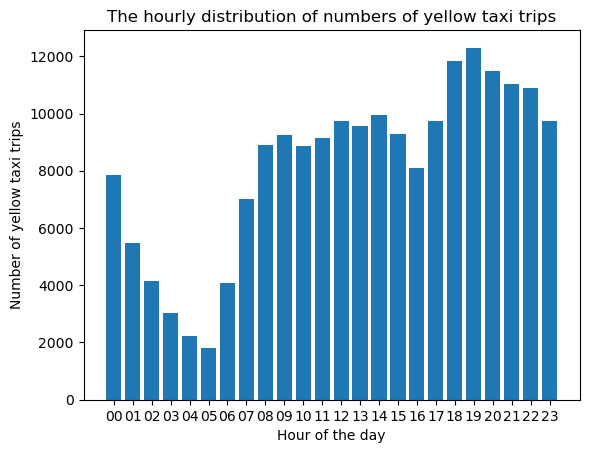

In [ ]:
plot_visual_1(dataframe)

### Visualization 2

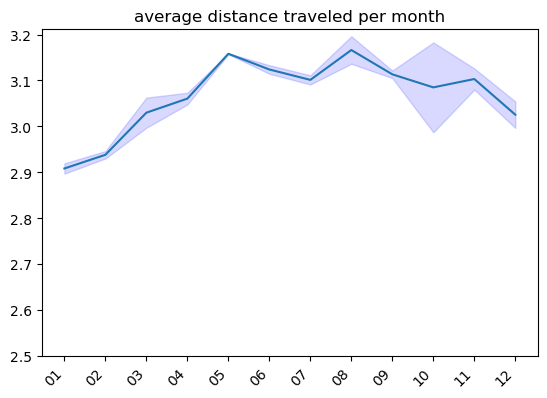

In [ ]:
QUERY_4_2 = """
SELECT month,
    total_trips,
    AVG(avr_distance) as average_distance,
    (count(distance)*sum(distance*distance) - (sum(distance)*sum(distance)))/((count(distance)-1)*(count(distance))) as variance
    FROM 
    (SELECT 
    trip_distance AS distance,
    strftime ('%m',pickup_datetime) AS month,
    count(*) AS	total_trips,
    AVG(trip_distance) AS avr_distance
    FROM 
    taxi_trips
    GROUP BY 
    strftime ('%m',pickup_datetime)
    UNION 
    SELECT 
    trip_distance AS distance,
    strftime ('%m',pickup_datetime) AS month,
    count(*) AS	total_trips,
    AVG(trip_distance) AS avr_distance
    FROM 
    uber_trips
    GROUP BY 
    strftime ('%m',pickup_datetime)
    )trips
    GROUP BY
    trips.month
"""

def get_data_for_visual_2():
    df = pd.read_sql(QUERY_4_2, con = engine)
    return df

df = get_data_for_visual_2()

ci_lower = df['average_distance'] - 1.64 *np.sqrt(df['variance'])/np.sqrt(df["total_trips"])
ci_upper = df['average_distance'] + 1.64 *np.sqrt(df['variance'])/np.sqrt(df["total_trips"])
fig, ax = plt.subplots()
x = df['month']
ax.plot(x, df['average_distance'])
ax.fill_between(x, ci_lower, ci_upper, color='b', alpha=.15)
ax.set_ylim(ymin=2.5)
ax.set_title('average distance traveled per month')
fig.autofmt_xdate(rotation=45)

### Visualization 3

In [ ]:
JFK_BOX = [-73.825248, 40.620479, -73.746971, 40.666458]
LGA_BOX = [-73.890716,40.767245,-73.854667,40.781415]
EWR_BOX = [-74.192324,40.670659,-74.153185, 40.708601]

In [ ]:
def plot_visual_3():
    query_JFK = """
    SELECT day, COUNT(day) AS Trip_counts
    FROM
    (SELECT strftime('%w', pickup_datetime) AS day, dropoff_longitude, dropoff_latitude from taxi_trips
    UNION ALL
    SELECT strftime('%w', pickup_datetime) AS day, dropoff_longitude, dropoff_latitude from uber_trips)
    WHERE dropoff_longitude BETWEEN -73.825248 AND -73.746971 AND dropoff_latitude BETWEEN 40.620479 AND 40.666458
    GROUP BY day
    ORDER BY Trip_counts
    """
    query_LGA = """
    SELECT day, COUNT(day) AS Trip_counts
    FROM
    (SELECT strftime('%w', pickup_datetime) AS day, dropoff_longitude, dropoff_latitude from taxi_trips
    UNION ALL
    SELECT strftime('%w', pickup_datetime) AS day, dropoff_longitude, dropoff_latitude from uber_trips)
    WHERE dropoff_longitude BETWEEN -73.890716 AND -73.854667 AND dropoff_latitude BETWEEN 40.767245 AND 40.781415
    GROUP BY day
    ORDER BY Trip_counts
    """

    query_EWR = """
    SELECT day, COUNT(day) AS Trip_counts
    FROM
    (SELECT strftime('%w', pickup_datetime) AS day, dropoff_longitude, dropoff_latitude from taxi_trips
    UNION ALL
    SELECT strftime('%w', pickup_datetime) AS day, dropoff_longitude, dropoff_latitude from uber_trips)
    WHERE dropoff_longitude BETWEEN -74.192324 AND -74.153185 AND dropoff_latitude BETWEEN 40.670659 AND 40.708601
    GROUP BY day
    ORDER BY Trip_counts
    """

    df_JFK = pd.read_sql(query_JFK, con = engine)
    df_LGA = pd.read_sql(query_LGA, con = engine)
    df_EWR = pd.read_sql(query_EWR, con = engine)
    
    barWidth = 0.25
    fig = plt.subplots(figsize =(12, 8))
    br1 = np.arange(len(df_JFK['day']))
    br2 = [x + barWidth for x in br1]
    br3 = [x + barWidth for x in br2]

    plt.bar(br1, df_JFK['Trip_counts'], color ='r', width = barWidth,
            edgecolor ='grey', label ='JFK')
    plt.bar(br2, df_LGA['Trip_counts'], color ='g', width = barWidth,
            edgecolor ='grey', label ='LGA')
    plt.bar(br3, df_EWR['Trip_counts'], color ='b', width = barWidth,
            edgecolor ='grey', label ='EWR')

    # Adding Xticks
    plt.xlabel('Days in Week', fontweight ='bold', fontsize = 15)
    plt.ylabel('Trip_counts', fontweight ='bold', fontsize = 15)

    plt.legend()
    plt.show()

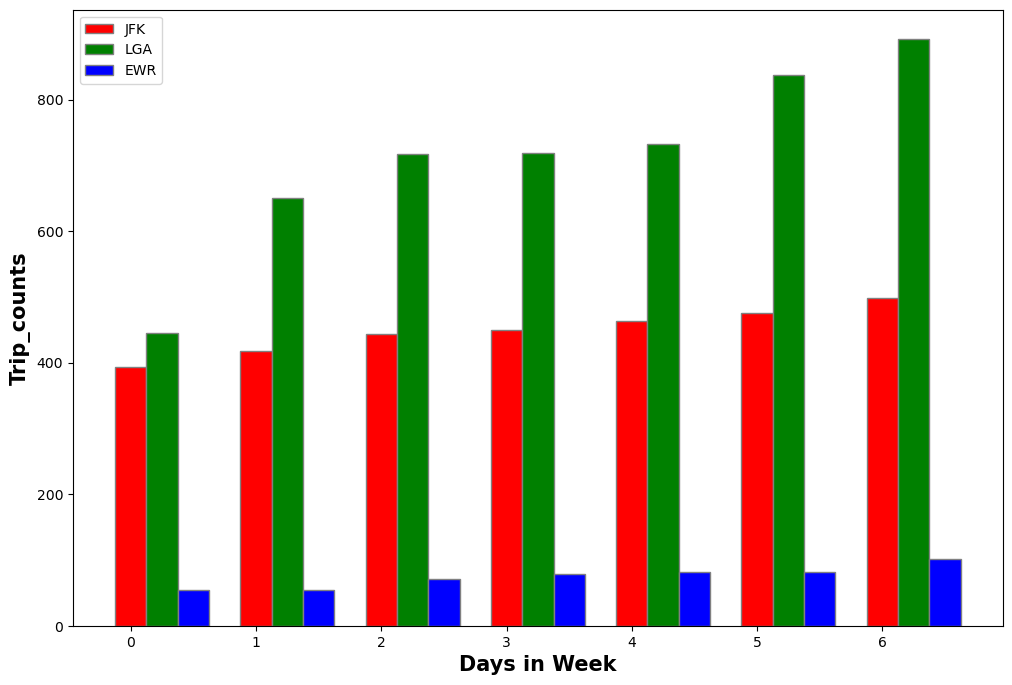

In [ ]:
plot_visual_3()

### Visualization 4

In [ ]:
get_map = KeplerGl(height = 500)
get_map.add_data(uber_data, name = "heatmap")
get_map.add_data(taxi_data, name = "heatmap")
get_map

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'heatmap': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,…

### Visualization 5

In [ ]:
def plot_visual_5():
    query_visual_5 = """
    SELECT tip_amount, trip_distance FROM taxi_trips
    """

    df_tip_distance = pd.read_sql(query_visual_5, con = engine)
    plt.scatter(x = df_tip_distance['tip_amount'], y = df_tip_distance['trip_distance'])
    plt.xlabel('tip_amount') 
    plt.ylabel('trip_distance') 
    plt.title('tip_amount vs. trip_distance')
    plt.show()

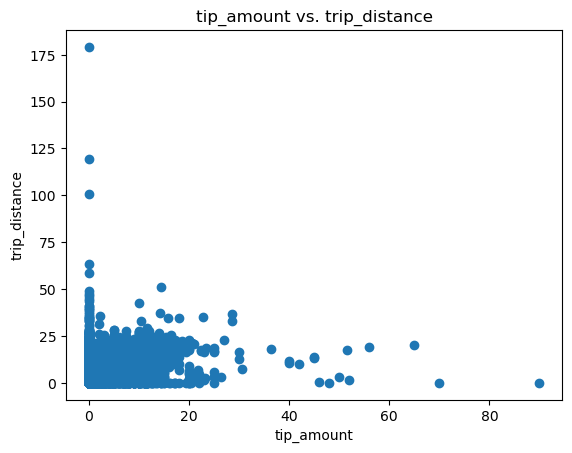

In [ ]:
plot_visual_5()

### Visualization 6

In [ ]:
def plot_visual_6():
    query_taxi ="""SELECT strftime('%Y-%m-%d %H', pickup_datetime) AS DATE, tip_amount
            FROM taxi_trips
            """ 
    query_weather ="""SELECT strftime('%Y-%m-%d %H', DATE) AS DATE, HourlyPrecipitation
            FROM hourly_weathers
            """

    taxi_data = pd.read_sql_query(query_taxi, con = engine)
    weather_data = pd.read_sql_query(query_weather, con = engine)
    
    taxi_data['DATE'] = pd.to_datetime(taxi_data['DATE'], format='%Y-%m-%d %H')
    weather_data['DATE'] = pd.to_datetime(weather_data['DATE'], format='%Y-%m-%d %H')

    df = pd.merge(taxi_data, weather_data, on='DATE')
    df = df[(df['HourlyPrecipitation'] > 0) & (df['tip_amount'] < 50)]
    
    # sample the data to make the scatter plot clearer
    df.plot(x="HourlyPrecipitation", y="tip_amount", kind="scatter", title="tip_amount vs. Precipitation")

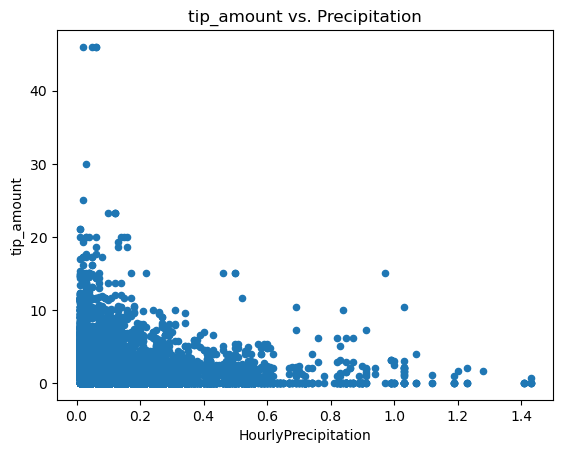

In [ ]:
plot_visual_6()

### Creating animation of our visualization 1 in part 4

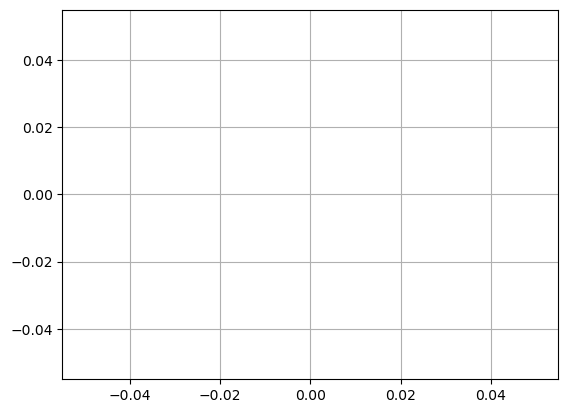

In [ ]:
# read the data of QUERY_1 in part 3
df = pd.read_sql_query(QUERY_1, engine).sort_values(by="HOUR", ascending=True)
df.index = df['HOUR']

def generate_data():
    for i in range(24):
        yield int(df['HOUR'][i]), int(df['Trip_counts'][i])

# initialize the plot
fig, ax = plt.subplots()
line, = ax.plot([], [], lw=2)
ax.grid()
x_data = []
y_data = []

# create a function that initializes the plot
def initialization():
    ax.set_ylim(0, 13000)
    ax.set_xlim(0, 23)
    ax.set_xlabel('Hour')
    ax.set_ylabel('Trip counts')
    ax.set_title('Trip counts of Each Hour of the Day')
    del x_data[:]
    del y_data[:]
    line.set_data(x_data, y_data)
    return line

# create a function that updates the data of each hour
def update(data: tuple):
    x, y = data
    x_data.append(x)
    y_data.append(y)
    line.set_data(x_data, y_data)
    return line

animation.FuncAnimation(fig, update, generate_data, interval=23,
                            repeat=False, init_func=initialization)

### Creating visualization of sunrise-sunset data

For this part of extra credit, we design a question:

What is the average tip amount of yellow taxi trips at day(during the time between sunrise and sunset) and at night(during the time between sunset and sunrise)?

To answer this question, we make a bar chart show the average tip amount of yellow taxi trips at day and at night.

In [ ]:
def plot_visual_sunrise_sunset():
    query_tip_amount = """
    SELECT date(pickup_datetime) AS DATE, pickup_datetime, tip_amount FROM taxi_trips
    """
    query_sun = """
    SELECT date(DATE) AS DATE, Sunrise, Sunset FROM sunrise_sunsets
    """

    tip_df = pd.read_sql_query(query_tip_amount, con = engine)
    sunrise_sunset_df = pd.read_sql_query(query_sun, con = engine)

    # convert the date to datetime
    tip_df['DATE'] = pd.to_datetime(tip_df['DATE'], format='%Y-%m-%d')
    tip_df['pickup_datetime']=[i.replace('UTC','') for i in tip_df['pickup_datetime']]
    tip_df['pickup_datetime'] = pd.to_datetime(tip_df['pickup_datetime'], format='%Y-%m-%d %H:%M:%S')
    sunrise_sunset_df['DATE'] = pd.to_datetime(sunrise_sunset_df['DATE'], format='%Y-%m-%d')

    # merge the two dataframes
    df = pd.merge(tip_df, sunrise_sunset_df, on='DATE')    

    # calculate the minutes using hour and minute
    df['Sunrise_minutes'] = df['Sunrise'].map(lambda x: int(str(x)[0]) * 60 + int(str(x)[1:]))
    df['Sunset_minutes'] = df['Sunset'].map(lambda x: int(str(x)[:2]) * 60 + int(str(x)[2:]))
    df['pickup_datetime_minutes'] = df['pickup_datetime'].map(lambda x: x.hour * 60 + x.minute)

    # find the trips that started during the day
    df['day'] = (df['pickup_datetime_minutes'] > df['Sunrise_minutes']) & (df['pickup_datetime_minutes'] < df['Sunset_minutes'])

    # Calculate the average tip amount during day and night
    tip_amount_day = []
    tip_amount_night = []
    for i in range(len(df.index)):
        if df['day'][i] == True:
            tip_amount_day.append(df["tip_amount"][i])
        else:
            tip_amount_night.append(df["tip_amount"][i])

    average_tip_day = statistics.mean(tip_amount_day)
    average_tip_night = statistics.mean(tip_amount_night)
    #plot a bar chart with average tip in day compared to in night
    plt.bar(['average_tip_day', 'average_tip_night'], [average_tip_day, average_tip_night], color ='maroon')
    plt.title('Average tip amount at day and at night')

In [ ]:
plot_visual_sunrise_sunset()